# XGBoost (Variance Threshold) Final Modeling

In [1]:
# Import libraries
import pandas as pd
import numpy as np

In [2]:
# Import final test dataframe
test = pd.read_csv('/content/drive/MyDrive/data/new_test_final.csv')

In [3]:
# Import final train datafram
train = pd.read_csv('/content/drive/MyDrive/data/new_train_final.csv')

In [4]:
# Define X
X_train = train.drop(columns=['imdb_id', 'rating_category', 'cleaned_review'])
X_test = test.drop(columns=['imdb_id', 'rating_category', 'cleaned_review'])

In [5]:
y_train = train['rating_category']
y_test = test['rating_category']

In [7]:
# Import
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold


In [13]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [8]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(objective='multi:softmax', num_class=4, seed=42)

# Create pipeline
xgb_pipeline = Pipeline([
    ('variance_threshold', VarianceThreshold()),
    ('classification', xgb_classifier)
])

In [9]:
# Define param grid
param_grid_xgb = {
    'variance_threshold__threshold': [0.0005, 0.0009],
    'classification__n_estimators': [30, 50],
    'classification__learning_rate': [0.05, 0.1],
    'classification__max_depth': [2, 3],
    'classification__min_child_weight': [2, 3],
    'classification__subsample': [0.7, 0.8],
    'classification__colsample_bytree': [0.7, 0.8]
}

In [11]:
from sklearn.model_selection import GridSearchCV

In [14]:
# Create the GridSearchCV object
grid_search_xgb = GridSearchCV(xgb_pipeline, param_grid_xgb, cv=5, n_jobs=-1, verbose=2, error_score='raise')

# Fit it to the data
grid_search_xgb.fit(X_train, y_train_encoded)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('variance_threshold',
                                        VarianceThreshold()),
                                       ('classification',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,...
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classification__colsample_bytree': [0.7, 0.8],
                         'classification__learning_rate': [0.05, 0.1],
                         'classification__max_depth': [2, 3],
                         'classification__min_child_weight': [2, 3],
                         'classification__n_estimators': [30, 50],
                         'classification__subsample': [0.7, 0.8],
                         'variance_threshold__threshold': [0.0005, 0.0009]},
             verbose=2)

In [18]:
# Importing the required libraries
from sklearn.metrics import accuracy_score

# Function for post grid search analysis
def post_grid_search_analysis(grid_search, X_test, y_test):
    # Get the best parameters
    best_params = grid_search.best_params_

    # Predict on the test set
    y_pred = grid_search.best_estimator_.predict(X_test)

    # Get the probability scores for the test set (useful for ROC curve, etc.)
    y_score = grid_search.best_estimator_.predict_proba(X_test)

    # Calculate the test accuracy
    test_accuracy = accuracy_score(y_test, y_pred)

    # Get the best score (mean cross-validated score of the best_estimator)
    best_score = grid_search.best_score_

    results = {
        'Best Parameters': best_params,
        'Best Score': best_score,
        'Test Accuracy': test_accuracy
    }

    return results

In [27]:
# Encode y_test
y_test_encoded = le.transform(y_test)

In [49]:
# Predict on the test set
y_pred_xgb_vt = grid_search_xgb.best_estimator_.predict(X_test)
y_score_xgb_vt = grid_search_xgb.best_estimator_.predict_proba(X_test)

In [50]:
# Execute the function and store the results
results_xgb_vt = post_grid_search_analysis(grid_search_xgb, X_test, y_test_encoded)

# Print the results
print(f"XGBoost (Variance Threshold) Best Parameters: {results_xgb_vt['Best Parameters']}")
print(f"XGBoost (Variance Threshold) Best Score: {results_xgb_vt['Best Score']}")
print(f"XGBoost Forest (Variance Threshold) Test Accuracy: {results_xgb_vt['Test Accuracy']}")

XGBoost (Variance Threshold) Best Parameters: {'classification__colsample_bytree': 0.7, 'classification__learning_rate': 0.1, 'classification__max_depth': 3, 'classification__min_child_weight': 3, 'classification__n_estimators': 50, 'classification__subsample': 0.7, 'variance_threshold__threshold': 0.0005}
XGBoost (Variance Threshold) Best Score: 0.6019312602291326
XGBoost Forest (Variance Threshold) Test Accuracy: 0.6094814038763751


In [58]:
import joblib

# Save the trained model
joblib.dump(grid_search_xgb.best_estimator_, '/content/drive/MyDrive/data/xgboost_vt_model.pkl')

['/content/drive/MyDrive/data/xgboost_vt_model.pkl']

In [32]:
# Get the class labels from the LabelEncoder
class_labels = le.classes_


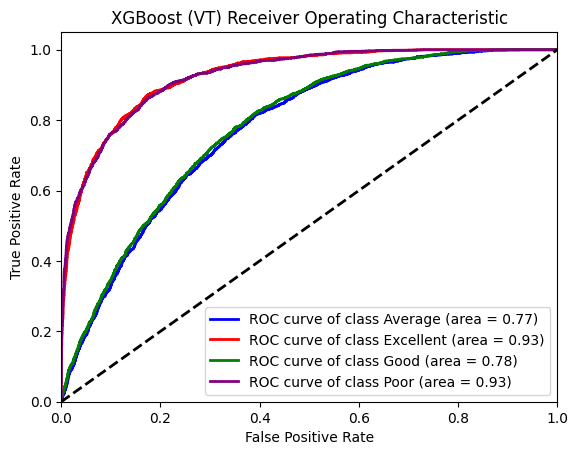

In [51]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# The number of unique classes
n_classes = len(np.unique(y_test_encoded))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded == i, y_score_xgb_vt[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost (VT) Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [52]:
from sklearn.metrics import classification_report

# Generate classification report
xbg_vt_report = classification_report(y_test_encoded, y_pred_xgb_vt, target_names=class_labels, output_dict=True)

# Convert the classification report to a dataframe
xbg_vt_report_df = pd.DataFrame(xbg_vt_report).transpose()

In [43]:
xbg_vt_report_df

,precision,recall,f1-score,support
Average,0.505473,0.413375,0.454809,1899.000000
Excellent,0.713812,0.733258,0.723404,1762.000000
Good,0.492414,0.540909,0.515523,1980.000000
Poor,0.717827,0.754887,0.735891,1995.000000
accuracy,0.609481,0.609481,0.609481,0.609481
macro avg,0.607381,0.610607,0.607407,7636.000000
weighted avg,0.605641,0.609481,0.605966,7636.000000


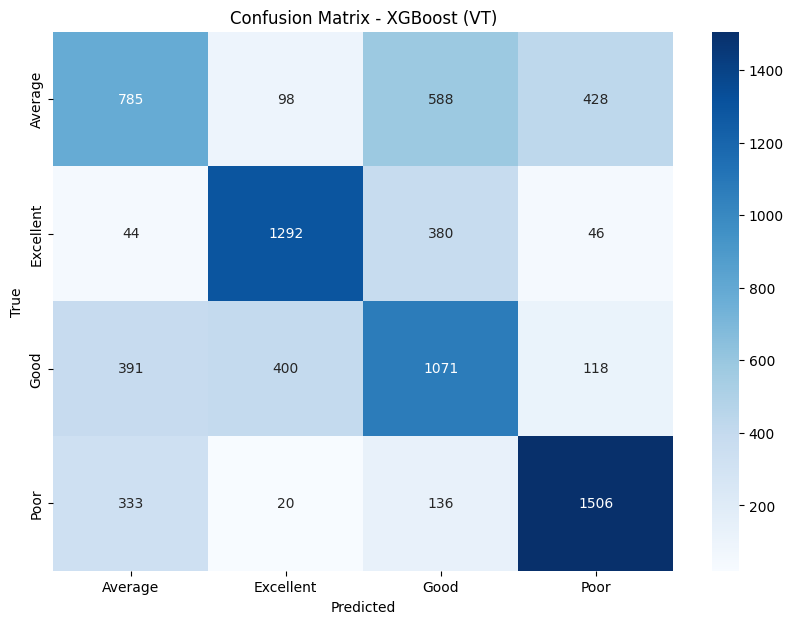

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate a confusion matrix for test and predicted labels
cm_xgb_vt = confusion_matrix(y_test_encoded, y_pred_xgb_vt)

# Create a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_xgb_vt, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XGBoost (VT)')
plt.show()
